In [ ]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed
import keras
from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
# from keras.utils import np_utils

from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

In [ ]:
# !pip install np_utils
# import utils
# from tensorflow.keras.utils import to_categorical
from keras.src.utils.np_utils import to_categorical

## Import the Datasets

I'll import the `.csv` file to read the labels.

In [ ]:
# dataset = pd.read_csv("/content/driver_imgs_list.csv")
# dataset.head(5)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip


Archive:  /content/state-farm-distracted-driver-detection.zip
replace driver_imgs_list.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_folder = "/content/imgs/train"

rename_folder_ls = {
    "c0": "safe_driving",
    "c1": "texting_right",
    "c2": "talking_on_the_phone_right",
    "c3": "texting_left",
    "c4": "talking_on_the_phone_left",
    "c5": "operating_the_radio",
    "c6": "drinking",
    "c7": "reaching_behind",
    "c8": "hair_and_makeup",
    "c9": "talking_to_passenger"
}

def rename_folder(base_folder, rename_folder):
  for old_name, new_name in rename_folder.items():
    old_path = os.path.join(base_folder, old_name)
    new_path = os.path.join(base_folder, new_name)

    if os.path.exists(old_path):
      os.rename(old_path, new_path)
      print(f"changed from {old_name} to {new_name}")
    else:
      print(f'folder {old_name} not found')

rename_folder(train_folder, rename_folder_ls)

## Count Images from each folder

In [ ]:
train_folder = "/content/imgs/train"

image_extensions = ['.jpg', '.jpeg', '.png']

def count_imageFiles(directory):
  count = 0
  for filename in os.listdir(directory):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
      count += 1

  return count

for folder in os.listdir(train_folder):
  folder_path = os.path.join(train_folder, folder)
  if os.path.isdir(folder_path):
    image_count = count_imageFiles(folder_path)
    print(f"{folder} : {image_count}")

In [ ]:
dataset = pd.read_csv("/content/driver_imgs_list.csv")
dataset.head(5)

## change coded classnames with proper word

In [ ]:
csv_file_path = "/content/driver_imgs_list.csv"

rename_class_ls = {
    "c0": "safe_driving",
    "c1": "texting_right",
    "c2": "talking_on_the_phone_right",
    "c3": "texting_left",
    "c4": "talking_on_the_phone_left",
    "c5": "operating_the_radio",
    "c6": "drinking",
    "c7": "reaching_behind",
    "c8": "hair_and_makeup",
    "c9": "talking_to_passenger"
}

df = pd.read_csv(csv_file_path)

df["classname"] = df['classname'].replace(rename_class_ls)

output_csv_path = "/content/driver_imgs_updted_list.csv"
df.to_csv(output_csv_path, index = False)

In [ ]:
dataset = pd.read_csv("/content/driver_imgs_updted_list.csv")
dataset.head(5)

From the csv file, We use the `classname` as the labels for the images and use the image names to match the labels with the correct images.

#### Import Driver Dataset

In [ ]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

In the following, we preparex the code to import the dataset of the driver images. then populate a few variables.

In [ ]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols))
    return img

# Define the folder name mapping
rename_folder_ls = {
    "c0": "safe_driving",
    "c1": "texting_right",
    "c2": "talking_on_the_phone_right",
    "c3": "texting_left",
    "c4": "talking_on_the_phone_left",
    "c5": "operating_the_radio",
    "c6": "drinking",
    "c7": "reaching_behind",
    "c8": "hair_and_makeup",
    "c9": "talking_to_passenger"
}

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = []
    train_labels = []
    # Loop over the training folder
    for classed, folder_name in rename_folder_ls.items():
        print('Loading directory {}'.format(folder_name))
        folder_path = os.path.join('/content/imgs/train', folder_name)
        files = glob(os.path.join(folder_path, '*.jpg'))
        print(files)
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(folder_name)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)

    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('/content/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)

    return test_data, test_ids

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1

In [ ]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

Loading directory safe_driving
['/content/imgs/train/safe_driving/img_64455.jpg', '/content/imgs/train/safe_driving/img_55325.jpg', '/content/imgs/train/safe_driving/img_100598.jpg', '/content/imgs/train/safe_driving/img_99086.jpg', '/content/imgs/train/safe_driving/img_32662.jpg', '/content/imgs/train/safe_driving/img_94690.jpg', '/content/imgs/train/safe_driving/img_1746.jpg', '/content/imgs/train/safe_driving/img_71240.jpg', '/content/imgs/train/safe_driving/img_47131.jpg', '/content/imgs/train/safe_driving/img_97807.jpg', '/content/imgs/train/safe_driving/img_35917.jpg', '/content/imgs/train/safe_driving/img_47634.jpg', '/content/imgs/train/safe_driving/img_82267.jpg', '/content/imgs/train/safe_driving/img_48161.jpg', '/content/imgs/train/safe_driving/img_66605.jpg', '/content/imgs/train/safe_driving/img_50792.jpg', '/content/imgs/train/safe_driving/img_28538.jpg', '/content/imgs/train/safe_driving/img_7044.jpg', '/content/imgs/train/safe_driving/img_10662.jpg', '/content/imgs/trai

ValueError: ignored

In [ ]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:00<02:06, 630.06it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


#### Statistics

In [ ]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("/content/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('/content/imgs/test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


#### Dataset Visualization

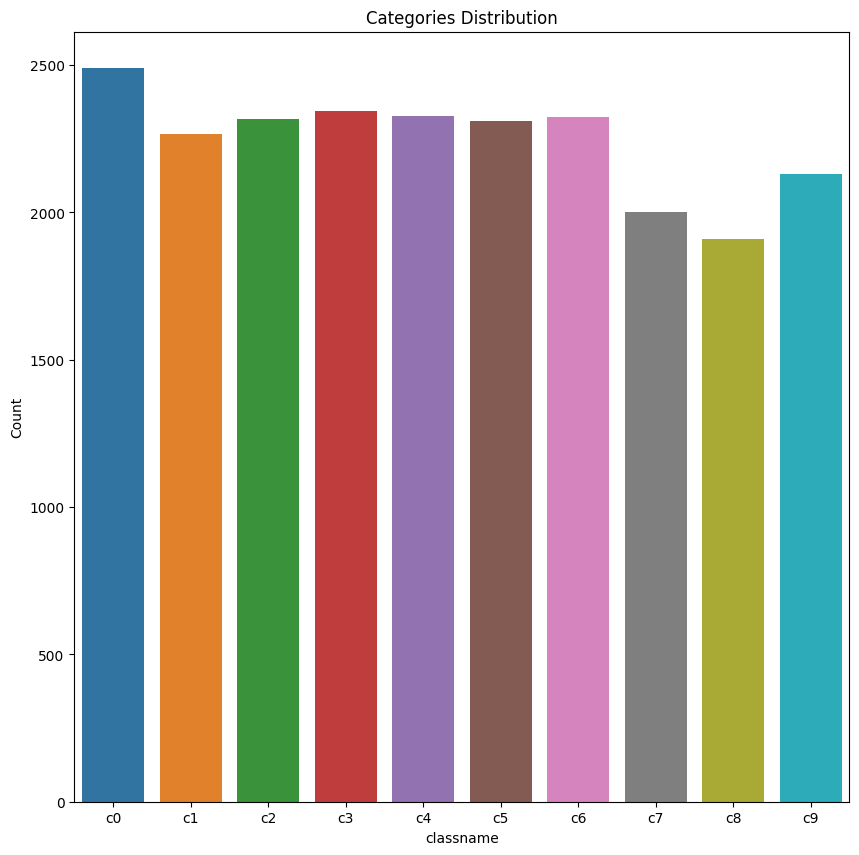

In [ ]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 2000x2000 with 0 Axes>

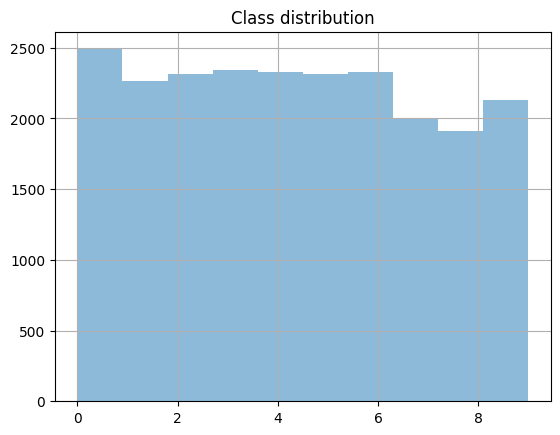

In [ ]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

#### Images overview

Let's take a look at the various images in the dataset. I'll plot an image for each of the 10 classes. As the directory names are not descriptive, I'll use a map to define the title for each image that is more descriptive.

In [ ]:
activity_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

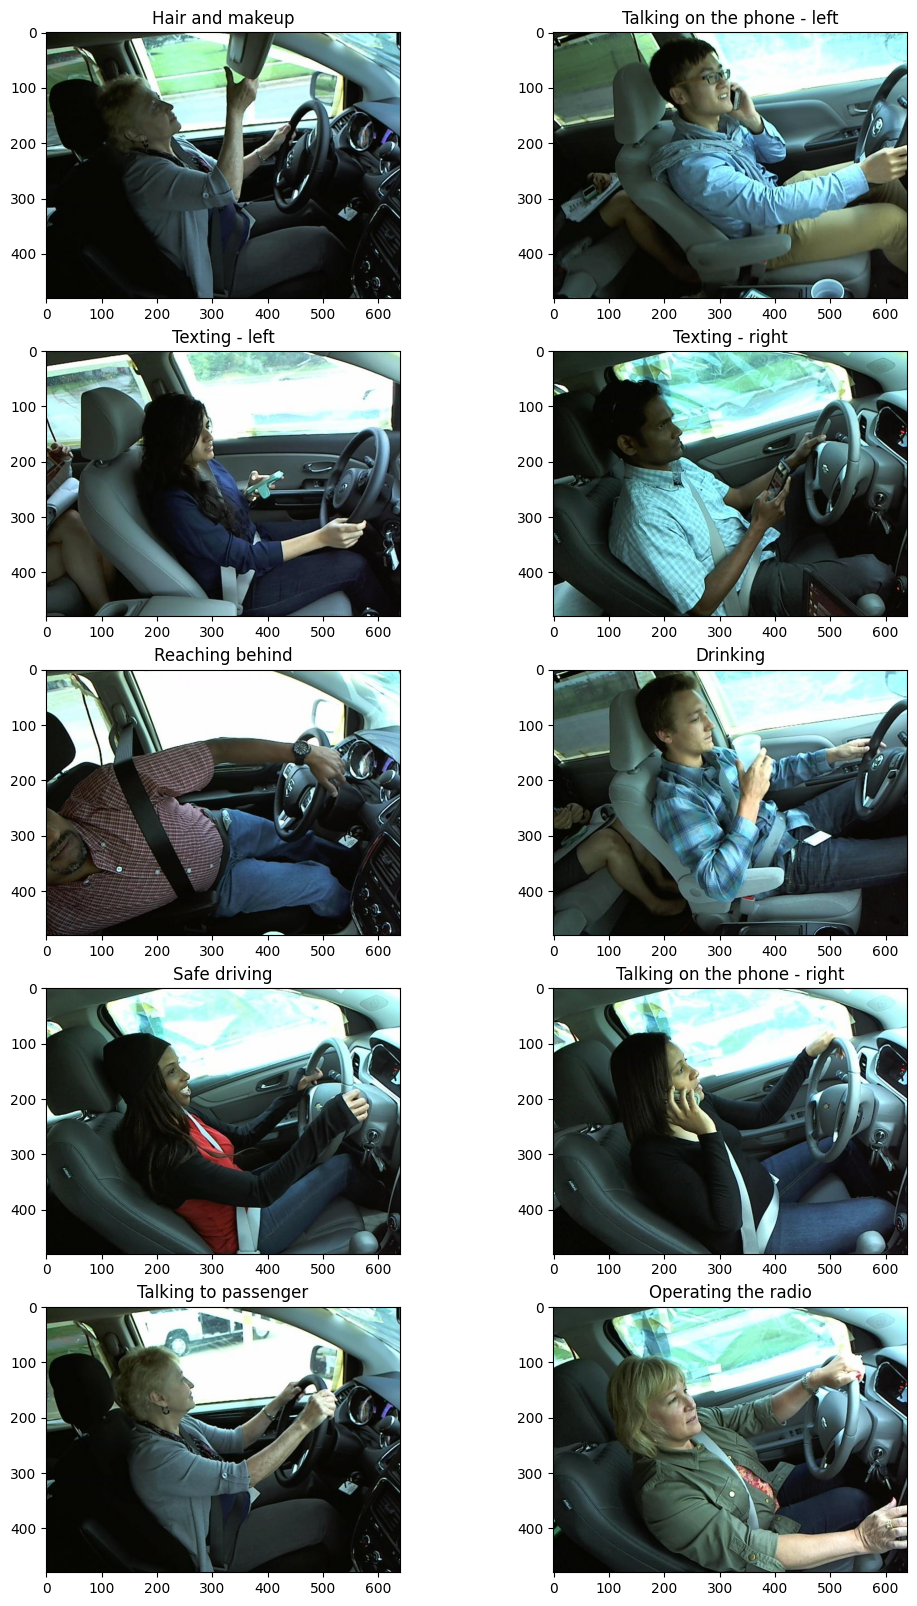

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [ ]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)

    now = datetime.datetime.now()

    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')

    result.to_csv(sub_file, index=False)

    return sub_file

## Create a vanilla CNN model

#### Building the model

I'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers. I'll use the optimizer as `rmsprop`, and loss as `categorical_crossentropy`.

In [ ]:
batch_size = 40
nb_epoch = 10

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5',
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

#### Model v1
---

In [ ]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))

    return model

In [ ]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 256)         0

In [ ]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 2.7088 - accuracy: 0.5007
Epoch 1: val_loss improved from inf to 0.39244, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 23s 22ms/step - loss: 2.7088 - accuracy: 0.5007 - val_loss: 0.3924 - val_accuracy: 0.8705
Epoch 2/10
447/449 [============================>.] - ETA: 0s - loss: 0.3309 - accuracy: 0.8998
Epoch 2: val_loss improved from 0.39244 to 0.13538, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 9s 19ms/step - loss: 0.3317 - accuracy: 0.8998 - val_loss: 0.1354 - val_accuracy: 0.9616
Epoch 3/10
446/449 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9447
Epoch 3: val_loss improved from 0.13538 to 0.07282, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 9s 19ms/step - loss: 0.2090 - accuracy: 0.9447 - val_loss: 0.0728 - val_accuracy: 0.982

Load the classifier with the best validation loss

In [ ]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

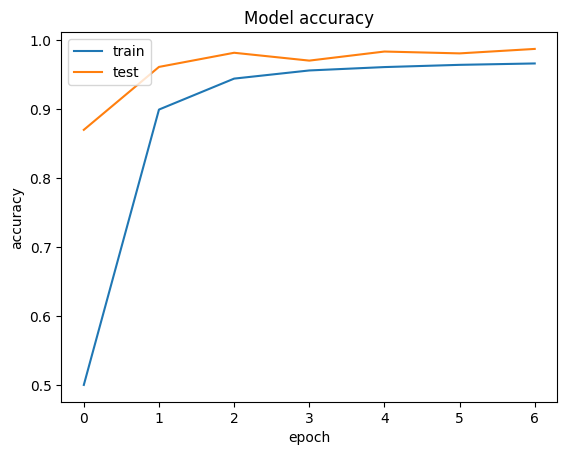

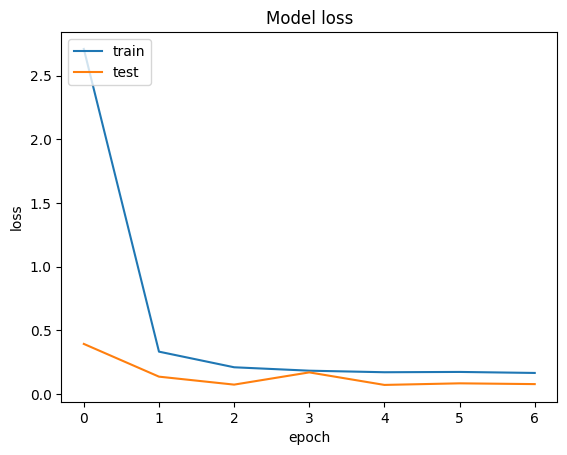

In [ ]:
plot_train_history(history_v1)


In [ ]:
import random
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap = 'gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)


    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))



In [ ]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

141/141 [==============================] - 1s 8ms/step - loss: 0.0705 - accuracy: 0.9839
Score:  [0.07045672833919525, 0.9839465022087097]


In [ ]:
test_files.shape

(200, 64, 64, 1)

1/1 [==============================] - 0s 76ms/step
Y prediction: [[8.1548357e-04 3.1429934e-04 1.4224095e-09 6.5113869e-05 3.6390216e-07
  2.4719164e-04 6.7238938e-07 7.8951800e-08 4.0750706e-01 5.9104967e-01]]
Predicted: Talking to passenger


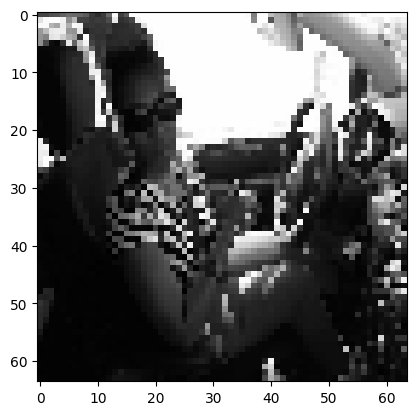

In [ ]:
plot_test_class(model_v1, test_files, 6)



1/1 [==============================] - 0s 40ms/step
Y prediction: [[1.2420783e-13 1.2635065e-10 9.9938560e-01 5.3785105e-21 1.6623655e-18
  1.0011452e-14 1.0490814e-04 3.3662363e-13 5.0944043e-04 7.0962258e-09]]
Predicted: Talking on the phone - right


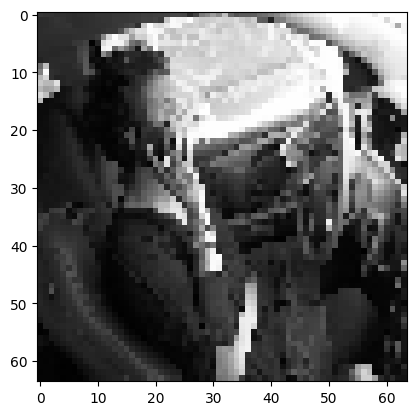

In [ ]:

plot_test_class(model_v1, test_files, 14)


1/1 [==============================] - 0s 20ms/step
Y prediction: [[1.5105129e-11 2.2211172e-11 2.3759559e-09 2.4973796e-14 1.9565119e-05
  2.8334322e-04 9.9969709e-01 1.2549199e-12 1.8712917e-08 2.8249392e-11]]
Predicted: Drinking


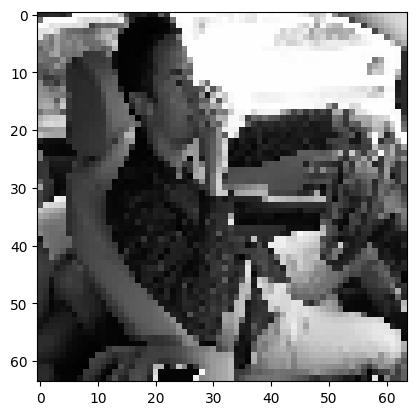

In [ ]:
plot_test_class(model_v1, test_files, 54)